Práctico 4 - Ramiro Sanes (368397) y Joaquín Guerra (307854)

# Práctico VAE (Variational AutoEncoders)

El objetivo de este práctico es explorar las Variational Autoencoders tanto en su implementación como sus bases teóricas.

In [1]:
import torch
import torchinfo
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

### Dataset

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

Running on cuda


In [3]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [4]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [5]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1*28*28).to(DEVICE)
flatten_batch.shape

torch.Size([100, 784])

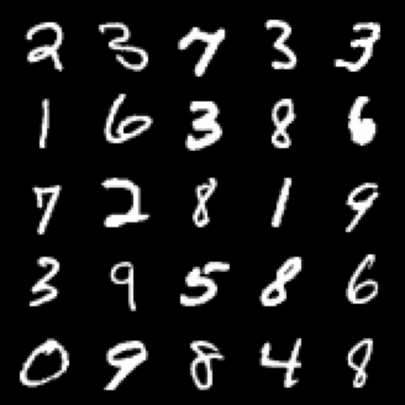

In [6]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

### Modelo VAE

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=200, latent_dim=2, device=DEVICE): #ignorar z_dim
        super(VAE, self).__init__()

        self.latent_dim = latent_dim 
        # Hiperparametro latent_dim: Dimensionalidad del espacio latente, probarla primero en 2, despues poder probar con mas
    

        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)


        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        # TODO: Completar esta sección. Debes codificar 'x' usando la capa encoder
        # computar la media y la varianza de la distribución latente.
        # Devuelve la media y varianza
        encoded = self.encoder(x)
        mean = self.mean_layer(encoded)
        logvar = self.logvar_layer(encoded)
        return mean, logvar


    def reparameterization(self, mean, var):
        z = mean + var * torch.randn_like(var)
        return z

    def decode(self, z):
        # TODO: Completar esta sección. Usar el decodificador para transformar 'z' 
        #      de nuevo a una representación del espacio original.
        # Devuelve la reconstrucción.
        reconstructed = self.decoder(z)
        return reconstructed

    def forward(self, x):

        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar
    
    def generate(self, num_samples=1):
        # TODO: Completar esta sección. Generar nuevas muestras a partir de la distribución latente.
        # Devuelve las nuevas muestras generadas.
        z = torch.randn(num_samples, self.latent_dim).to(self.device)
        samples = self.decode(z)
        return samples

In [8]:
LR = 1e-3

model = VAE(device=DEVICE).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [9]:
torchinfo.summary(model, input_size=(100,784), col_names = ('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                --
├─Sequential: 1-1                        [100, 784]                [100, 400]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─ReLU: 2-2                         [100, 400]                [100, 400]                --
│    └─Linear: 2-3                       [100, 400]                [100, 400]                160,400
│    └─ReLU: 2-4                         [100, 400]                [100, 400]                --
├─Linear: 1-2                            [100, 400]                [100, 2]                  802
├─Linear: 1-3                            [100, 400]                [100, 2]                  802
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-5     

###  Función de Pérdida

In [10]:
def loss_function(x, x_hat, mean, log_var):
    # TODO: Completar esta sección. Implementar la función de pérdida de la VAE.
    # 1) Calcule la pérdida de reconstrucción (reconstruction loss) entre x y x_hat.
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # 2) Calcule la divergencia KL (Kullback-Leibler divergence) entre la distribución latente y una distribución normal estándar.
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # 3) Devuelva la pérdida.
    return reproduction_loss + KLD

### Entrenamiento

In [11]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [12]:
loss_original = train(model.to(DEVICE), optimizer, epochs=15, device=DEVICE)

	Epoch 1 	Average Loss:  171.83761971449812
	Epoch 2 	Average Loss:  150.60181720510747
	Epoch 3 	Average Loss:  145.91277004643155
	Epoch 4 	Average Loss:  142.95715934434995
	Epoch 5 	Average Loss:  141.01334390325022
	Epoch 6 	Average Loss:  139.53452094636896
	Epoch 7 	Average Loss:  138.41471523176648
	Epoch 8 	Average Loss:  137.48998198494888
	Epoch 9 	Average Loss:  136.98342088702526
	Epoch 10 	Average Loss:  136.32421250586916
	Epoch 11 	Average Loss:  135.71912719115193
	Epoch 12 	Average Loss:  135.22192459437605
	Epoch 13 	Average Loss:  134.95473707807284
	Epoch 14 	Average Loss:  134.59937209802797
	Epoch 15 	Average Loss:  133.95139927222453


### Generación

In [13]:
def generate_digit(z_dim=2):
    x_decoded = model.generate()
    digit = x_decoded.detach().cpu().reshape(28, 28)
    #plt.title(f'[{z_sample[0,0]},{z_sample[0,1]}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

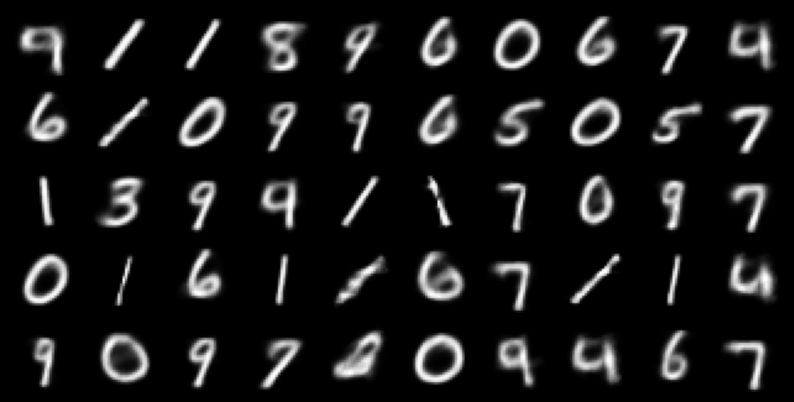

In [14]:
# Generate 50 digits using the VAE
num_generated = 50
generated_images = model.generate(num_samples=num_generated)

# Reshape to 28x28 for visualization
generated_images = generated_images.view(num_generated, 28, 28).detach().cpu()

# Create a grid to display the generated digits
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1)

for ax, img in zip(grid, generated_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()

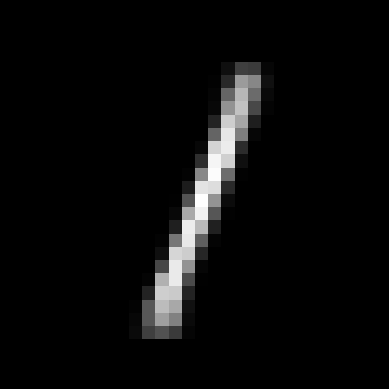

In [15]:
generate_digit()

### Mostrar el espacio latente

In [16]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

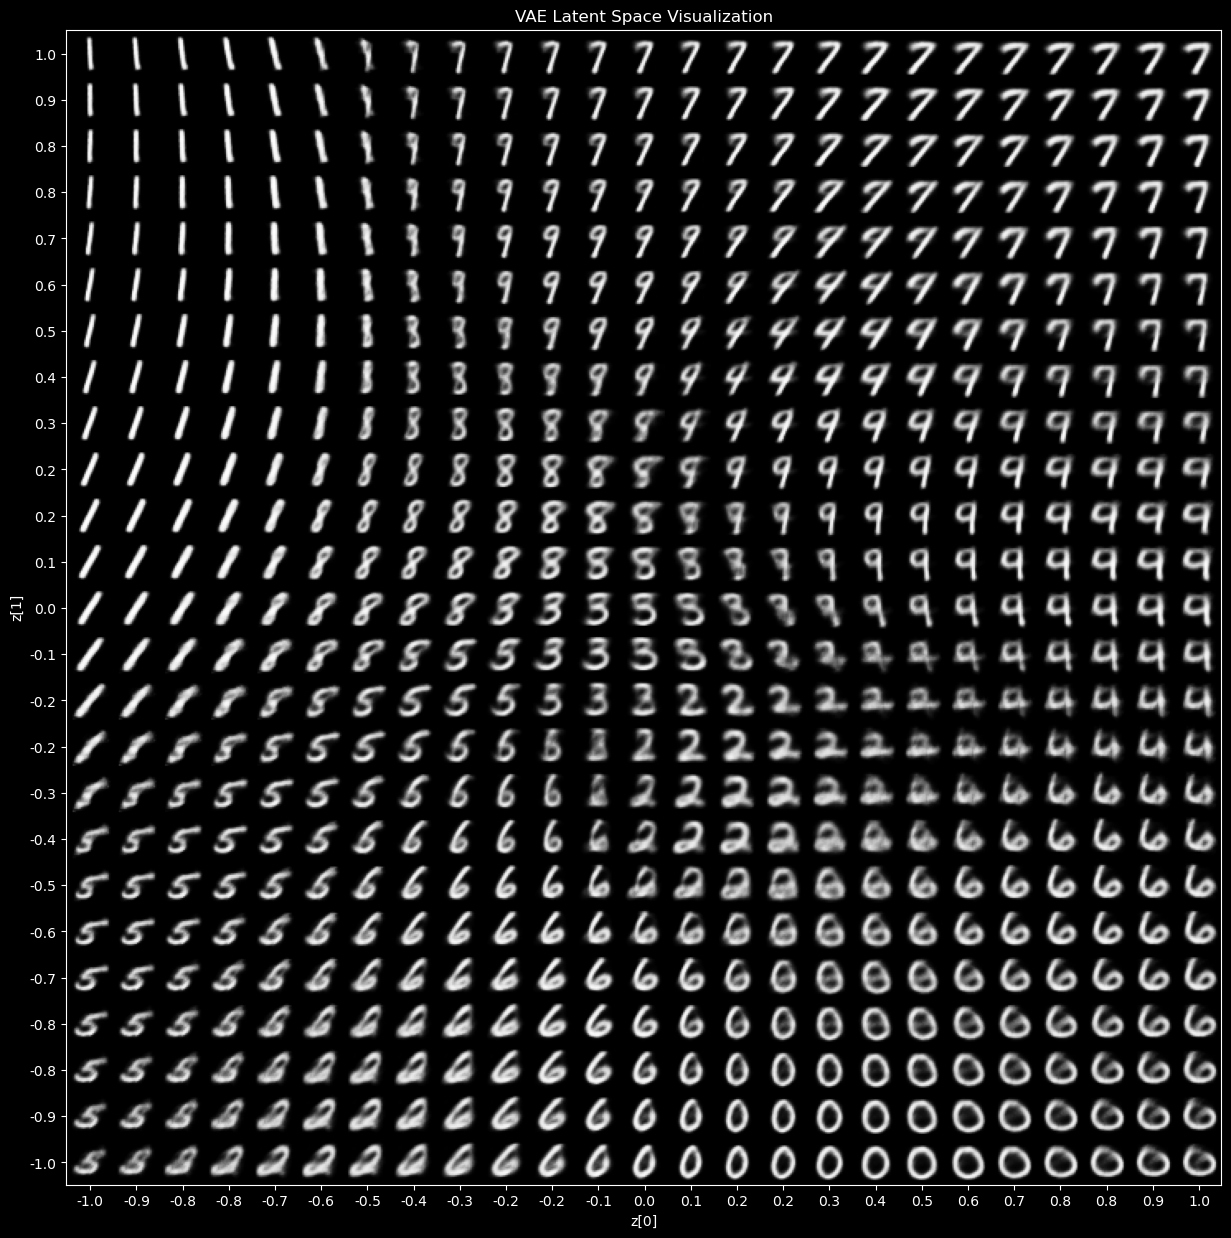

In [17]:
plot_latent_space(model, scale=1)

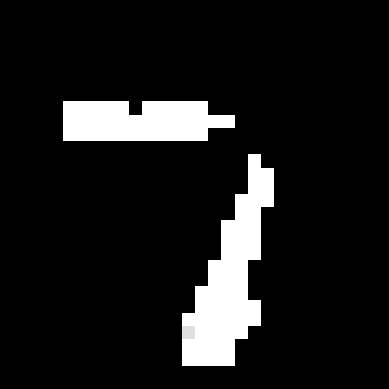

In [18]:
plt.imshow(model.decode(torch.tensor([+140.8,+880.5]).to(DEVICE).unsqueeze(0)).view(28,28).detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

## Ejercicios

1. Complete el código.
2. ¿Por qué es necesario el truco de reparametrización en las VAE?
3. ¿Qué representan las variables mean y var en la VAE?
4. Cree y entrene nuevas VAE modificando los hiperparámetros.
5. ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?
6. ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?
7. Explique que ve en la imágen que se genera cuando llamamos a la función `plot_latent_space`. Si cambiamos la dimensión del espacio latente, ¿qué pasaría con esta gráfica?

### Ejercicio 2: ¿Por qué es necesario el truco de reparametrización en las VAE?

El **truco de reparametrización** es fundamental en las VAEs (Variational Autoencoders) para que el modelo pueda aprender usando backpropagation a pesar de que involucra una parte aleatoria (muestreo).
El vector latente z se muestrea de una normal y este muestreo no es diferenciable por lo que no podemos actualizar $\mu$  y  $\sigma$ mediante backpropagation.
El truco nos permite actualizar todos los pesos mediante descenso de gradiente.


### Ejercicio 3: ¿Qué representan las variables mean y var en la VAE?

* mean: representa la media de la distribución gaussiana del espacio latente (Z) para una muestra dada (z). Es el punto donde el modelo “cree” que debería estar la representación latente de esa entrada.

* var: representa la dispersión o incertidumbre de esa distribución, es decir, cuán seguros estamos de que el punto latente esté cerca de la media. Una varianza alta significa que el modelo no está tan seguro, y una baja indica más confianza.


### Ejercicio 4: Crear y entrenar nuevas VAE modificando los hiperparámetros

Vamos a experimentar con diferentes configuraciones de hiperparámetros para observar cómo afectan el rendimiento:

Probamos con un espacio latente de 10 dimensiones

EXPERIMENTO 1: VAE con latent_dim=10
	Epoch 1 	Average Loss:  146.15265331542153
	Epoch 2 	Average Loss:  98.55987514998957
	Epoch 3 	Average Loss:  91.7053874051153
	Epoch 4 	Average Loss:  88.34182594363001
	Epoch 5 	Average Loss:  86.16066035351889
	Epoch 6 	Average Loss:  84.61894598093176
	Epoch 7 	Average Loss:  83.28804563595575
	Epoch 8 	Average Loss:  82.30438265435883
	Epoch 9 	Average Loss:  81.45305131762574
	Epoch 10 	Average Loss:  80.73636441595367


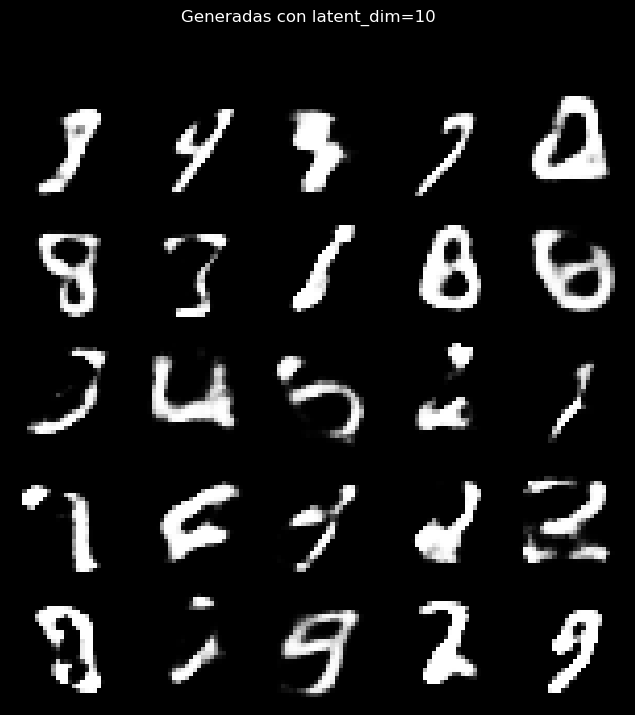

In [23]:
print("="*60)
print("EXPERIMENTO 1: VAE con latent_dim=10")
print("="*60)

model_10d = VAE(input_dim=784, hidden_dim=400, latent_dim=10, device=DEVICE).to(DEVICE)
optimizer_10d = Adam(model_10d.parameters(), lr=1e-3)

loss_10d = train(model_10d, optimizer_10d, epochs=10, device=DEVICE, x_dim=784)

# Generar y visualizar
generated_10d = model_10d.generate(num_samples=25).view(25, 28, 28).detach().cpu()
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, img in zip(grid, generated_10d):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generadas con latent_dim=10')
plt.show()

Probamos con una red mas profunda (hidden_dim = 800)

EXPERIMENTO 2: VAE con hidden_dim=800
	Epoch 1 	Average Loss:  166.35349769146495
	Epoch 2 	Average Loss:  148.81376672709723
	Epoch 3 	Average Loss:  144.4818781139138
	Epoch 4 	Average Loss:  141.8281065610653
	Epoch 5 	Average Loss:  139.68554077759808
	Epoch 6 	Average Loss:  138.46080723732263
	Epoch 7 	Average Loss:  137.27970398254905
	Epoch 8 	Average Loss:  136.7273047038032
	Epoch 9 	Average Loss:  135.8557471925866
	Epoch 10 	Average Loss:  135.1985176629017


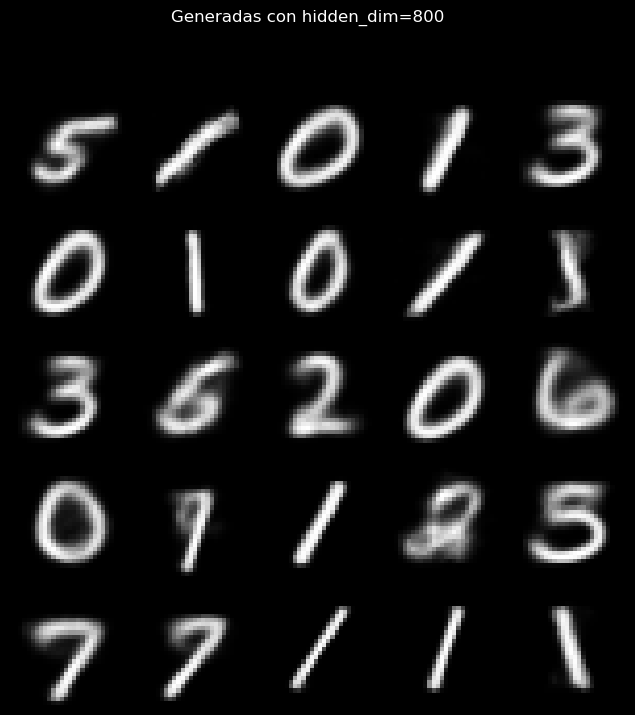

In [20]:
print("="*60)
print("EXPERIMENTO 2: VAE con hidden_dim=800")
print("="*60)

model_deep = VAE(input_dim=784, hidden_dim=800, latent_dim=2, device=DEVICE).to(DEVICE)
optimizer_deep = Adam(model_deep.parameters(), lr=1e-3)

loss_deep = train(model_deep, optimizer_deep, epochs=10, device=DEVICE, x_dim=784)

# Generar y visualizar
generated_deep = model_deep.generate(num_samples=25).view(25, 28, 28).detach().cpu()
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, img in zip(grid, generated_deep):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generadas con hidden_dim=800')
plt.show()

Probamos cambiando el learning rate (lr=5e-4)

EXPERIMENTO 3: VAE con learning_rate=5e-4
	Epoch 1 	Average Loss:  180.56645370865505
	Epoch 2 	Average Loss:  154.9697450177379
	Epoch 3 	Average Loss:  150.81140569569072
	Epoch 4 	Average Loss:  147.86426180678734
	Epoch 5 	Average Loss:  145.52005262677378
	Epoch 6 	Average Loss:  143.7383066341037
	Epoch 7 	Average Loss:  142.52844173883557
	Epoch 8 	Average Loss:  141.59865332194283
	Epoch 9 	Average Loss:  140.30197484088063
	Epoch 10 	Average Loss:  139.57998754434473


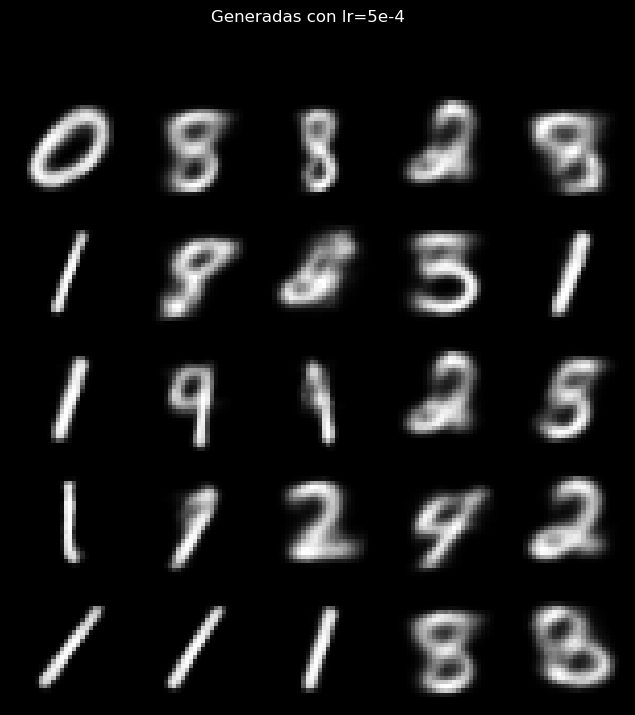

In [21]:
print("="*60)
print("EXPERIMENTO 3: VAE con learning_rate=5e-4")
print("="*60)

model_lr = VAE(input_dim=784, hidden_dim=400, latent_dim=2, device=DEVICE).to(DEVICE)
optimizer_lr = Adam(model_lr.parameters(), lr=5e-4)

loss_lr = train(model_lr, optimizer_lr, epochs=10, device=DEVICE, x_dim=784)

# Generar y visualizar
generated_lr = model_lr.generate(num_samples=25).view(25, 28, 28).detach().cpu()
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, img in zip(grid, generated_lr):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generadas con lr=5e-4')
plt.show()

In [22]:
# Comparación de pérdidas entre modelos
print("\n" + "="*60)
print("COMPARACIÓN DE PÉRDIDAS FINALES")
print("="*60)
print(f"Modelo original (latent_dim=2, hidden=400, lr=1e-3): {loss_original/(len(train_loader)*batch_size):.4f}")
print(f"Modelo con latent_dim=10: {loss_10d/(len(train_loader)*batch_size):.4f}")
print(f"Modelo con hidden_dim=800: {loss_deep/(len(train_loader)*batch_size):.4f}")
print(f"Modelo con lr=5e-4: {loss_lr/(len(train_loader)*batch_size):.4f}")
print("="*60)


COMPARACIÓN DE PÉRDIDAS FINALES
Modelo original (latent_dim=2, hidden=400, lr=1e-3): 133.7281
Modelo con latent_dim=10: 80.7254
Modelo con hidden_dim=800: 134.9732
Modelo con lr=5e-4: 139.3474


Si bien el modelo con latent_dim = 10, es el que tiene menor perdida en el entrenamiento, no termina siendo el mejor modelo para generar imagenes

### Ejercicio 5: ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?

**Espacio latente pequeño (ej. latent_dim=2):**

**Ventajas:**
- Podemos graficar directamente en 2D (como vimos con `plot_latent_space`)
- El modelo aprende las características más importantes
- Entrenamiento más rápido y menos memoria
- Evita sobreajuste

**Desventajas:**
- No puede capturar toda la variabilidad de los datos
- Imágenes más borrosas

**Espacio latente grande (ej. latent_dim=10, 20, 50):**

**Ventajas:**
- Puede modelar más variaciones en los datos


**Desventajas:**
- No podemos graficar
- Riesgo de overfitting
- Más parámetros = más cómputo


### Ejercicio 6: ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?

La **KL-divergence** es uno de los 2 componentes de la función de perdida de las VAEs. Obliga a que las distribuciones latentes que el encoder aprende (definidas por mean y var) no se alejen demasiado de una distribución normal estándar N(0,1).
Es una forma de ordenar nuestro espacio latente.

### Ejercicio 7: Explicar la imagen de `plot_latent_space` y efecto de cambiar dimensión latente

**¿Qué vemos en la visualización del espacio latente?**

La visualización muestra en el eje x, la primer componente de nuestro espacio latente de dimensión 2 z[0] y en el eje y, la segunda z[1]. En el grafico podemos observar, que imágen generaría nuestro decoder, al recibir como entrada cada muestra del espacio latente  z[0] y z[1].

Se observa como al movernos por el espacio latente, no hay saltos bruscos en la imagen generada, sino que van cambiando "suavemente" y que diferentes regiones contienen diferentes dígitos

**¿Qué pasaría si cambiamos latent_dim?**

**Si latent_dim = 1**
- NO podemos usar `plot_latent_space` tal como está (espera 2 dimensiones)
- Mucha menos capacidad expresiva, todos los dígitos en una sola línea

**Si latent_dim = 3 o más:**
- NO podemos visualizar `plot_latent_space` directamente
